In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# imports
import pickle as pkl # pickle files
import numpy as np # good to have
import pandas as pd # dataframes
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
from statsmodels.tsa.stattools import grangercausalitytests # granger causality test for causality
from statsmodels.tsa.stattools import adfuller # augmented dickey-fuller test for stationarity
#import statsmodels.tsa.vector_ar.vecm as VAR # VAR model
from statsmodels.tsa.api import VAR # VAR model
import os
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from matplotlib import pylab, mlab, pyplot
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam

In [3]:
# making sure pandas version is same as pickled version
pd.__version__

'2.0.3'

In [4]:
jacob_path = '/content/drive/MyDrive/DS for Ag - Spring 24 (Time Series)'

base_path = jacob_path # just change this line
data_path = os.path.join(base_path, 'Spring 2024', 'Data')

In [5]:
fname = 'p13_final_df_ind_imputed.pkl'

fpath = os.path.join(data_path, fname)

print(fpath)

# /content/drive/MyDrive/Colab Notebooks/DISC OU/DS for Ag - Spring 24 (Time Series)/Spring 2024/Data/p13_final_df_ind_imputed.pkl

/content/drive/MyDrive/DS for Ag - Spring 24 (Time Series)/Spring 2024/Data/p13_final_df_ind_imputed.pkl


In [6]:
# file name
fname = 'p13_final_df_ind_imputed.pkl'

fpath = os.path.join(data_path, fname)

# loads data and shows the column names
with open(fpath, 'rb') as fp:
    dat = pkl.load(fp)
    print(dat.keys())

Index(['TMAX', 'TMIN', 'TAVG', 'HAVG', 'VDEF', 'HDEG', 'CDEG', 'WSPD', 'ATOT',
       'RAIN', 'SAVG', 'BAVG', 'TR05', 'TR25', 'TR60', 'EVI', 'LSWI',
       'RAIN_7_Days', 'RAIN_14_Days', 'RAIN_21_Days', 'RAIN_28_Days'],
      dtype='object')


TMAX - max air temp  
TMIN - min air temp  
TAVG - avg air temp  
HAVG - avg relative humidity  
VDEF - avg daily vapor deficit  
HDEG - heating degree days        
CDEG - cooling degree days  
ATOT - solar radiation  
RAIN - daily rainfall  
SAVG - avg soil temp 10 cm under sod  
BAVG - avg soil temp 10 cm under bare soil  
TR05 - soil moisture calibrated delta-T at 5 cm  
TR25 - soil moisture calibrated delta-T at 25 cm  
TR60 - soil moisture calibrated delta-T at 60 cm  

In [7]:
# # save a model/data to pickle for later use

# output_fname = 'var_model.pkl'
# out_fpath = os.path.join(data_path, output_fname)
# with open(fpath, 'wb') as fp:
#     pkl.dump(var_model, fp, protocol=pkl.HIGHEST_PROTOCOL)


In [8]:
# # Load a model/data to pickle for instant use without the need to retrain/execute
# fname = 'var_model.pkl'
# fpath = os.path.join(data_path, fname)

# # loads data and shows the column names
# with open(fpath, 'rb') as fp:
#     var_model = pkl.load(fp)


In [9]:
dat.head()

,TMAX,TMIN,TAVG,HAVG,VDEF,HDEG,CDEG,WSPD,ATOT,RAIN,...,BAVG,TR05,TR25,TR60,EVI,LSWI,RAIN_7_Days,RAIN_14_Days,RAIN_21_Days,RAIN_28_Days
Date,,,,,,,,,,,,,,,,,,,,,
2000-03-16,51.91,30.63,35.60,99.84,0.01,23.73,0.0,12.53,1.95,0.23,...,49.05,1.5728,1.5437,1.4708,0.1671,-0.2239,0.54,1.31,2.60,3.08
2000-03-17,44.02,31.91,38.90,99.32,0.06,27.03,0.0,4.99,3.44,0.40,...,43.58,1.5291,1.5439,1.4723,0.1700,-0.2250,0.93,1.64,2.42,3.48
2000-03-18,47.59,39.43,42.18,91.32,0.85,21.49,0.0,8.90,5.66,0.02,...,46.06,1.5287,1.5465,1.4685,0.1741,-0.2236,0.95,1.66,2.44,3.50
2000-03-19,60.55,37.21,46.12,67.95,4.29,16.12,0.0,11.10,23.28,0.00,...,48.53,1.5285,1.5431,1.4681,0.1782,-0.2200,0.95,1.66,2.44,3.50
2000-03-20,73.85,37.63,55.00,57.60,8.43,9.26,0.0,15.37,23.64,0.00,...,50.28,1.5416,1.5443,1.4706,0.1825,-0.2141,0.95,1.66,2.44,3.50


In [10]:
# check for missing values
dat.isna().sum()

TMAX            0
TMIN            0
TAVG            0
HAVG            0
VDEF            0
HDEG            0
CDEG            0
WSPD            0
ATOT            0
RAIN            0
SAVG            0
BAVG            0
TR05            0
TR25            0
TR60            0
EVI             0
LSWI            0
RAIN_7_Days     0
RAIN_14_Days    0
RAIN_21_Days    0
RAIN_28_Days    0
dtype: int64

## Initial Visualization of each feature

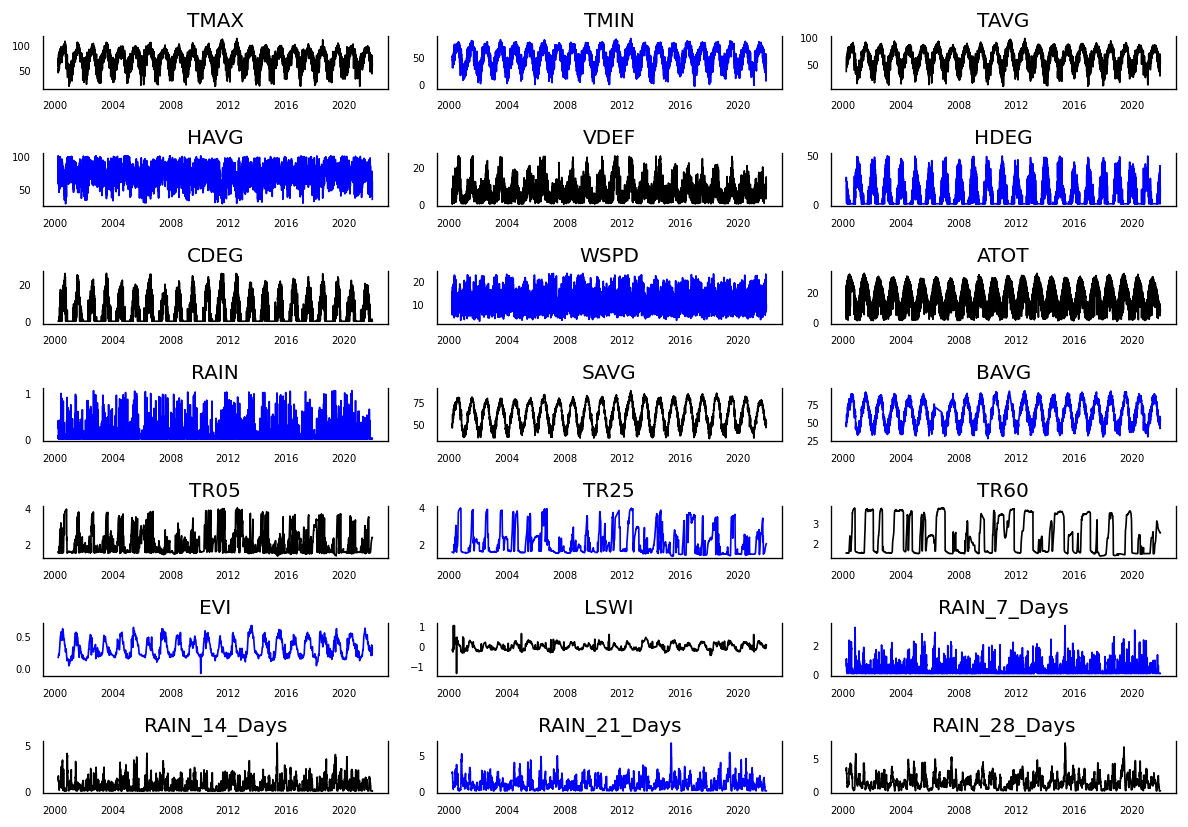

In [11]:

colors = ['black', 'blue']

# plotting
fig, axes = plt.subplots(nrows=7, ncols=3, dpi=120, figsize=(10, 7))

for i, ax in enumerate(axes.flatten()):
    data = dat[dat.columns[i]]
    ax.plot(data, color= colors[i % 2], linewidth=1)
    # Decorations
    ax.set_title(dat.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

# Adjust layout to avoid overlapping titles and x-axis labels
plt.tight_layout()
plt.show()



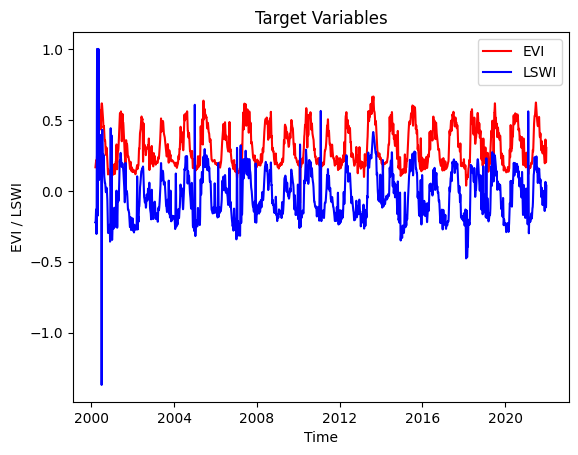

In [13]:
# EVI and LSWI over time

plt.plot(dat['EVI'], color = 'red', label = 'EVI')
plt.plot(dat['LSWI'], color = 'blue', label = 'LSWI')
plt.title('Target Variables')
plt.xlabel('Time')
plt.ylabel('EVI / LSWI')
plt.legend()
plt.show()

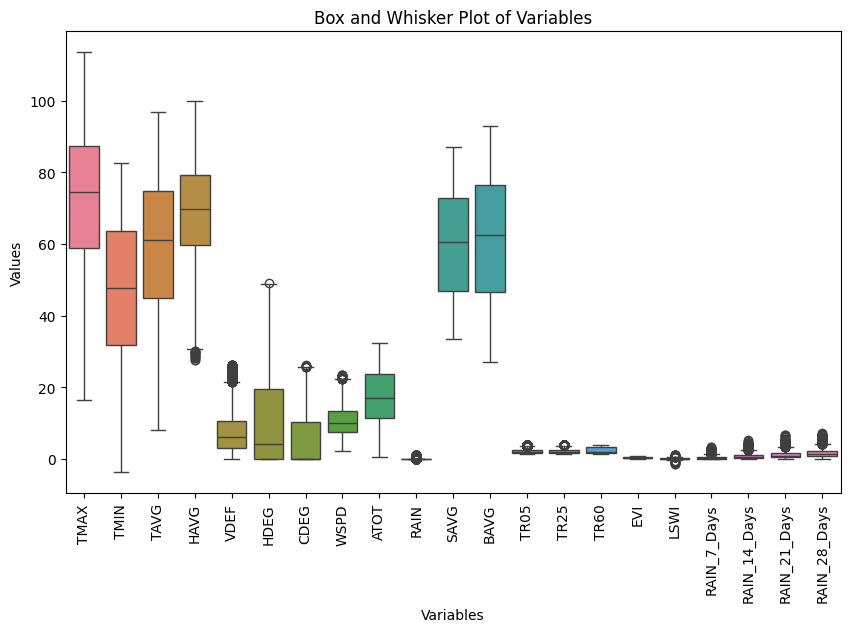

In [14]:
# boxplots

plt.figure(figsize=(10, 6))
sns.boxplot(data = dat)
plt.xticks(rotation=90)  # Rotate variable names to be vertical
plt.title('Box and Whisker Plot of Variables')
plt.xlabel('Variables')
plt.ylabel('Values')
plt.show()

In [15]:
temp_df = ['RAIN', 'TR05', 'TR25', 'TR60', 'EVI', 'LSWI', 'RAIN_7_Days', 'RAIN_14_Days', 'RAIN_21_Days', 'RAIN_28_Days']

temp_bx = dat[temp_df]

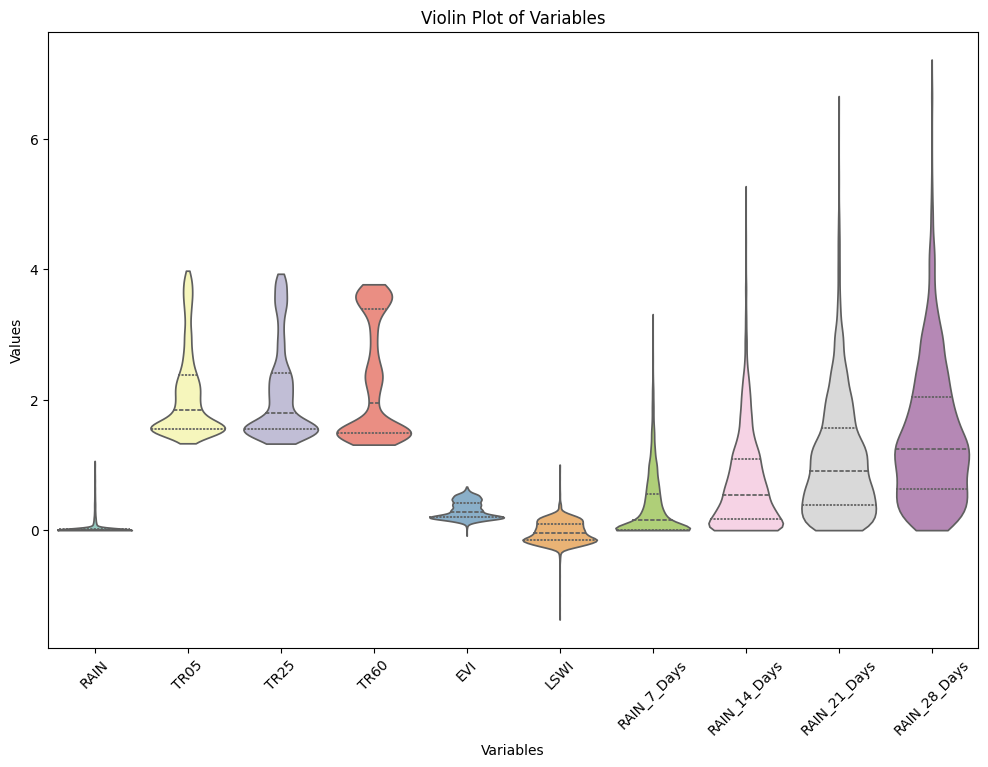

In [ ]:
# Create violin plot with lower range variables
plt.figure(figsize=(12, 8))  # Set figure size
sns.violinplot(data=temp_bx, inner="quartile", palette="Set3", cut=0)  # Create violin plot
plt.title('Violin Plot of Variables')  # Set title
plt.xlabel('Variables')  # Set x-axis label
plt.ylabel('Values')  # Set y-axis label
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()  # Show plot

In [ ]:
dat[['EVI']].describe()

,EVI
count,7957.000000
mean,0.310289
std,0.134959
min,-0.085000
25%,0.196200
50%,0.278600
75%,0.423000
max,0.666900


## Scaling

In [16]:
scaler = MinMaxScaler() # make scaler object

scaled_data = scaler.fit_transform(dat) # fit the data

In [17]:
# Convert back to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=dat.columns, index = dat.index)

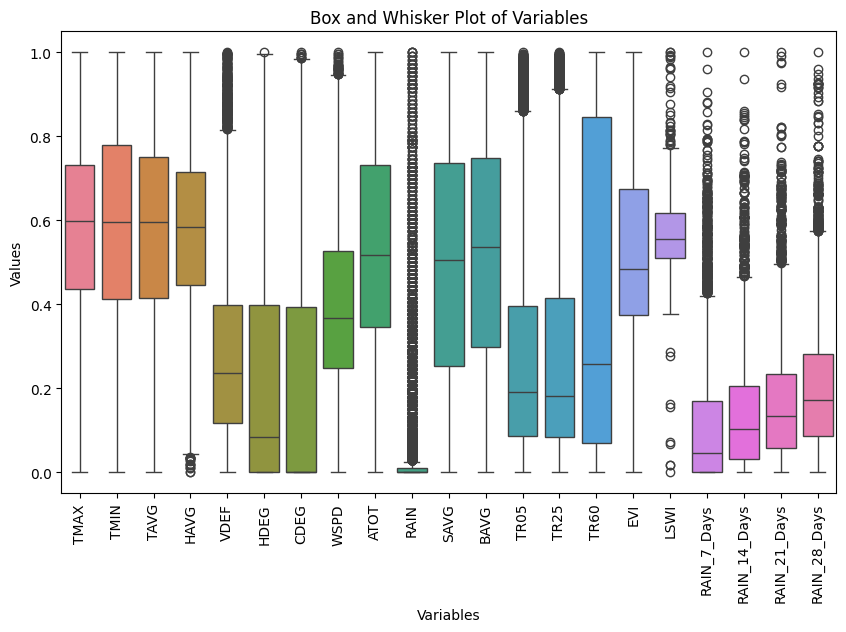

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data = scaled_df)
plt.xticks(rotation=90)  # Rotate variable names to be vertical
plt.title('Box and Whisker Plot of Variables')
plt.xlabel('Variables')
plt.ylabel('Values')
plt.show()

In [ ]:
# time series metrics function

from tabulate import tabulate

def metrics (true_val, pred_val):

    true_val = true_val.values.flatten()  # Convert DataFrame column to numpy array
    pred_val = pred_val.values.flatten()  # Convert DataFrame column to numpy array

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(true_val, pred_val)

    # Mean Squared Error (MSE)
    mse = mean_squared_error(true_val, pred_val)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Mean Absolute Percentage Error (MAPE)
    mask = true_val != 0
    mape = np.mean(np.abs((true_val[mask] - pred_val[mask]) / true_val[mask])) * 100

    # r squared
    rsq = r2_score(true_val, pred_val)


    table = [["MAE", mae], ["MSE", mse], ["RMSE", rmse], ["MAPE", mape], ["R2", rsq]]

    return table

## Correlation

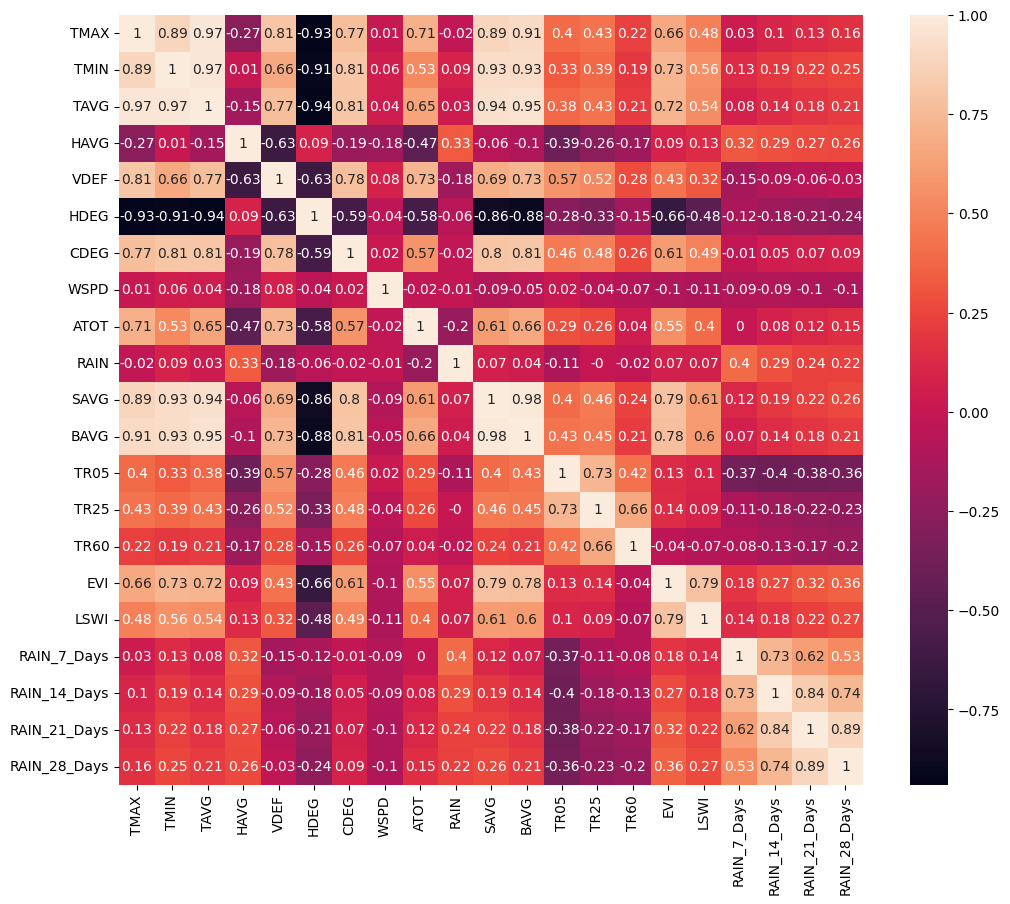

In [ ]:
matrix = scaled_df.corr()
rounded = matrix.round(2)

fig, ax = plt.subplots(figsize = (12, 10))
sns.heatmap(rounded, annot = True, cmap = 'rocket')
sns.set(font_scale = 0.6)


In [ ]:
evi = rounded['EVI'] # Extracting the EVI column from correlation matrix
evi = evi.drop('EVI') # Dropping it from results
highest = evi.nlargest(5) # Selecting the 5 largest correlations
highest

SAVG    0.79
LSWI    0.79
BAVG    0.78
TMIN    0.73
TAVG    0.72
Name: EVI, dtype: float64

In [ ]:
lswi = rounded['LSWI']
lswi = lswi.drop('LSWI')
highest = lswi.nlargest(5)
highest

EVI     0.79
SAVG    0.61
BAVG    0.60
TMIN    0.56
TAVG    0.54
Name: LSWI, dtype: float64

In [18]:
# Checking stationarity using augmented dickey fuller test

for i in range(len(scaled_df.columns)):
  result = adfuller(scaled_df[scaled_df.columns[i]])

  if result[1] > 0.05:
    print('{} - Series is not stationary.'.format(scaled_df).columns[i])
  else:
    print('{} - Series is stationary.'.format(scaled_df.columns[i]))


TMAX - Series is stationary.
TMIN - Series is stationary.
TAVG - Series is stationary.
HAVG - Series is stationary.
VDEF - Series is stationary.
HDEG - Series is stationary.
CDEG - Series is stationary.
WSPD - Series is stationary.
ATOT - Series is stationary.
RAIN - Series is stationary.
SAVG - Series is stationary.
BAVG - Series is stationary.
TR05 - Series is stationary.
TR25 - Series is stationary.
TR60 - Series is stationary.
EVI - Series is stationary.
LSWI - Series is stationary.
RAIN_7_Days - Series is stationary.
RAIN_14_Days - Series is stationary.
RAIN_21_Days - Series is stationary.
RAIN_28_Days - Series is stationary.


In [ ]:
max_lags = 10
y = 'EVI'

In [ ]:
from warnings import simplefilter
simplefilter(action = 'ignore', category = FutureWarning)

for i in range(len(scaled_df.columns) - 1):
  results = grangercausalitytests(scaled_df[[y, scaled_df.columns[i+1]]], max_lags, verbose = False)
  p_values = [round(results[i+1][0]['ssr_ftest'][1], 4) for i in range(max_lags)]
  print('Column - {} : P_Values - {}'.format(scaled_df.columns[i+1], p_values))

Column - TMIN : P_Values - [0.6413, 0.0, 0.0641, 0.0001, 0.1631, 0.0037, 0.003, 0.0, 0.0, 0.0]
Column - TAVG : P_Values - [0.1209, 0.0, 0.0452, 0.0, 0.0634, 0.0014, 0.0023, 0.0, 0.0, 0.0]
Column - HAVG : P_Values - [0.0, 0.1859, 0.0731, 0.5603, 0.2146, 0.4199, 0.4757, 0.5683, 0.1168, 0.1659]
Column - VDEF : P_Values - [0.0, 0.0, 0.038, 0.6126, 0.136, 0.543, 0.5638, 0.3599, 0.0002, 0.0352]
Column - HDEG : P_Values - [0.0049, 0.0, 0.0002, 0.0, 0.0007, 0.0, 0.0002, 0.0, 0.0, 0.0]
Column - CDEG : P_Values - [0.0, 0.0, 0.011, 0.602, 0.1089, 0.5791, 0.3382, 0.1816, 0.0001, 0.0674]
Column - WSPD : P_Values - [0.102, 0.0, 0.0, 0.0005, 0.0, 0.0, 0.0, 0.0, 0.001, 0.0]
Column - ATOT : P_Values - [0.0005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Column - RAIN : P_Values - [0.0, 0.0, 0.0, 0.0001, 0.0001, 0.0007, 0.0005, 0.0165, 0.0667, 0.0159]
Column - SAVG : P_Values - [0.0, 0.0, 0.1559, 0.0029, 0.1971, 0.0001, 0.0, 0.0, 0.0, 0.0]
Column - BAVG : P_Values - [0.0008, 0.0, 0.2569, 0.0001, 0.3433

In [ ]:
df_input = scaled_df[['EVI', 'TAVG', 'HDEG', 'WSPD', 'ATOT', 'RAIN', 'TR60']]

In [ ]:
# Specify the cut-off point
cut_off_date = '2020-01-01' # using the last two years (2020, 2021) as the test data

# Training data
training = df_input.loc[df_input.index < cut_off_date] # (2000 - 2019)

# Select all rows on and after the cut-off date
test = df_input.loc[df_input.index >= cut_off_date] # (2020 - 2021)

In [ ]:
lags = [2, 10, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 365]

model = VAR(training, freq = 'D')

for i in lags:
  results = model.fit(i + 1)
  print("Order: ", i+1)
  print("AIC: ", results.aic)
  print("BIC: ", results.bic)

Order:  3
AIC:  -42.92080828656016
BIC:  -42.77408361368655
Order:  11
AIC:  -43.856796971651775
BIC:  -43.336098598178445
Order:  31
AIC:  -44.08453402466251
BIC:  -42.62579388821687
Order:  61
AIC:  -43.92291642161891
BIC:  -41.04872835135204
Order:  91
AIC:  -43.76423388857565
BIC:  -39.46443240361726
Order:  121
AIC:  -43.59309609476946
BIC:  -37.85739800556459
Order:  151
AIC:  -43.414750055516265
BIC:  -36.23275259294646
Order:  181
AIC:  -43.221291841557814
BIC:  -34.582470748241754
Order:  211
AIC:  -43.059253079925405
BIC:  -32.952960662770124
Order:  241
AIC:  -42.96077215558088
BIC:  -31.376235298627698
Order:  271
AIC:  -42.80624651647063
BIC:  -29.732564653052222
Order:  301
AIC:  -42.66131767935296
BIC:  -28.08746072254915
Order:  331
AIC:  -42.53747163046633
BIC:  -26.452277860816647
Order:  366
AIC:  -42.39145225588852
BIC:  -24.528746421361788


In [ ]:
model.select_order(365).summary()

,AIC,BIC,FPE,HQIC
0,-25.15,-25.15,1.191e-11,-25.15
1,-38.33,-38.27,2.264e-17,-38.31
2,-41.07,-40.96,1.461e-18,-41.03
3,-42.91,-42.76,2.307e-19,-42.86
4,-43.07,-42.87,1.966e-19,-43.00
5,-43.22,-42.97,1.702e-19,-43.13
6,-43.27,-42.97,1.615e-19,-43.17
7,-43.28,-42.94,1.591e-19,-43.16
8,-43.40,-43.00,1.423e-19,-43.26
9,-43.49,-43.05,1.294e-19,-43.34


BIC 12  
HQIC 19  
AIC FPE 27  


## Lag 12

In [ ]:
model = VAR(training, freq = 'D')
results = model.fit(12)

In [ ]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 01, Mar, 2024
Time:                     16:19:20
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -43.3431
Nobs:                     7218.00    HQIC:                  -43.7153
Log likelihood:           87375.0    FPE:                8.50899e-20
AIC:                     -43.9106    Det(Omega_mle):     7.83948e-20
--------------------------------------------------------------------
Results for equation EVI
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.000477         0.000171            2.794           0.005
L1.EVI           3.321534         0.011529          288.095           0.000
L1.TAVG          0.000468         0.000317            1.475           0.140
L1.HDE

In [ ]:
lag = results.k_ar
lag

12

In [ ]:
results.forecast(training.values[-lag:], steps = 5)

array([[0.31303575, 0.34393438, 0.50059355, 0.31599967, 0.33105166,
        0.02410025, 0.39283133],
       [0.31124969, 0.38146953, 0.45061106, 0.38358604, 0.3102326 ,
        0.02618646, 0.37733986],
       [0.3075559 , 0.38020203, 0.46105603, 0.41994575, 0.31230743,
        0.04378171, 0.36215524],
       [0.30254653, 0.3821461 , 0.45258743, 0.41417479, 0.32034046,
        0.02888983, 0.35497937],
       [0.29648884, 0.3795805 , 0.44886003, 0.40857864, 0.31771703,
        0.01354721, 0.34750989]])

In [ ]:
coefs = pd.DataFrame([results.params['EVI'], results.pvalues['EVI']]).T
coefs

,EVI,EVI
const,0.000477,0.005212
L1.EVI,3.321534,0.000000
L1.TAVG,0.000468,0.140102
L1.HDEG,0.000079,0.675763
L1.WSPD,0.000014,0.824223
...,...,...
L12.HDEG,0.000078,0.677266
L12.WSPD,0.000073,0.255158
L12.ATOT,0.000035,0.611847
L12.RAIN,-0.000032,0.663892


In [ ]:
# Generate forecasts
forecast = results.forecast(training.values, steps=12)  # Adjust the steps as needed

# Convert forecast array to DataFrame with proper date index
forecast_index = pd.date_range(start=training.index[-1], periods=13, freq='D')[1:]  # Adjusted to include all forecasted periods
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=training.columns)



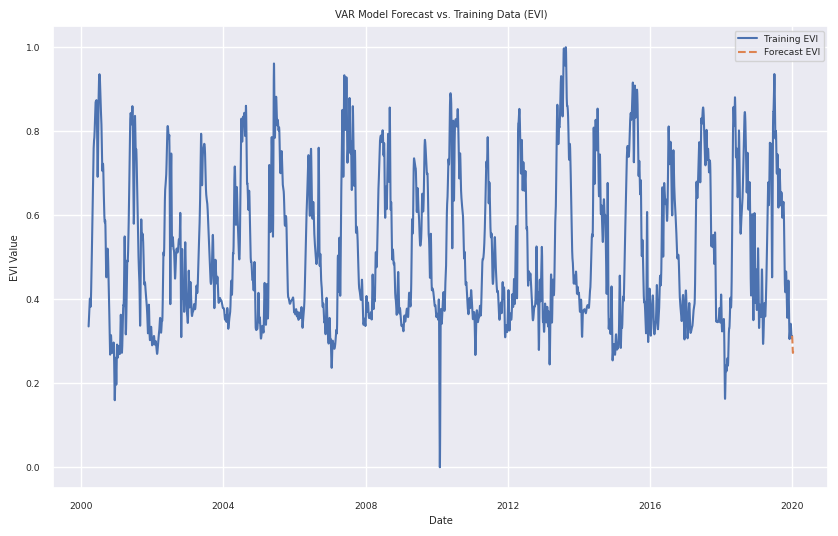

In [ ]:
# Plotting only EVI data
plt.figure(figsize=(10, 6))
plt.plot(training.index, training['EVI'], label='Training EVI')
plt.plot(forecast_df.index, forecast_df['EVI'], label='Forecast EVI', linestyle='--')

plt.title('VAR Model Forecast vs. Training Data (EVI)')
plt.xlabel('Date')
plt.ylabel('EVI Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
forecast = results.forecast(training.values, steps=len(test))  # Forecast the same length as the test data

# Convert forecast array to DataFrame with proper date index
forecast_index = pd.date_range(start=test.index[0], periods=len(test), freq='D')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=test.columns)


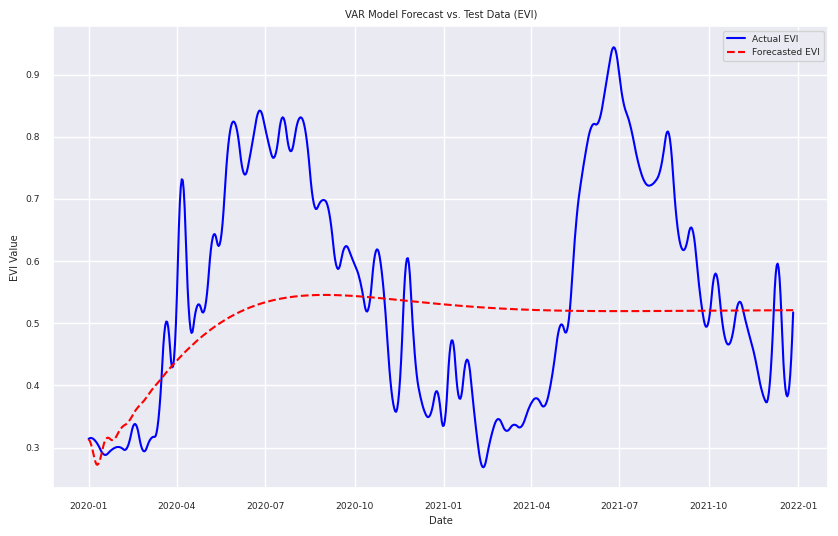

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['EVI'], label='Actual EVI', color='blue')
plt.plot(forecast_df.index, forecast_df['EVI'], label='Forecasted EVI', linestyle='--', color='red')

plt.title('VAR Model Forecast vs. Test Data (EVI)')
plt.xlabel('Date')
plt.ylabel('EVI Value')
plt.legend()
plt.grid(True)
plt.show()

## Lag 19

In [ ]:
model = VAR(training, freq = 'D')
results = model.fit(19)

In [ ]:
# Generate forecasts
forecast = results.forecast(training.values, steps=12)  # Adjust the steps as needed

# Convert forecast array to DataFrame with proper date index
forecast_index = pd.date_range(start=training.index[-1], periods=13, freq='D')[1:]  # Adjusted to include all forecasted periods
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=training.columns)

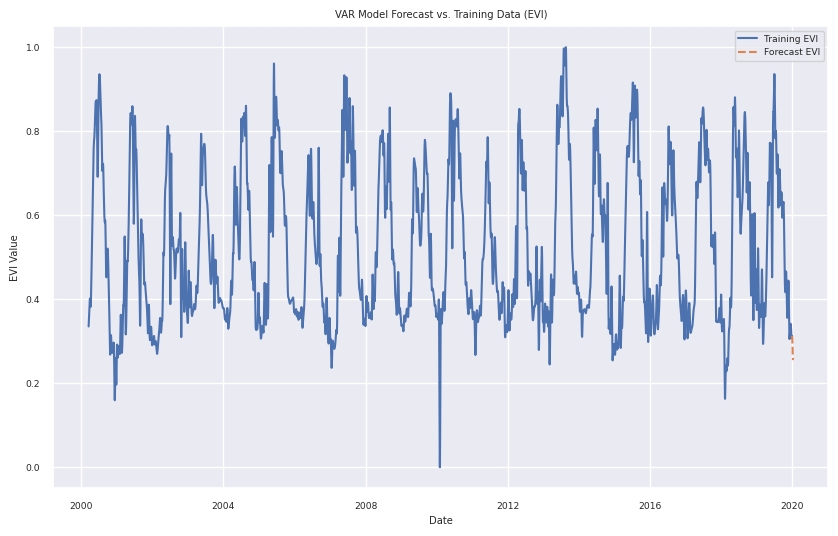

In [ ]:
# Plotting only EVI data
plt.figure(figsize=(10, 6))
plt.plot(training.index, training['EVI'], label='Training EVI')
plt.plot(forecast_df.index, forecast_df['EVI'], label='Forecast EVI', linestyle='--')

plt.title('VAR Model Forecast vs. Training Data (EVI)')
plt.xlabel('Date')
plt.ylabel('EVI Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
forecast = results.forecast(training.values, steps=len(test))  # Forecast the same length as the test data

# Convert forecast array to DataFrame with proper date index
forecast_index = pd.date_range(start=test.index[0], periods=len(test), freq='D')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=test.columns)

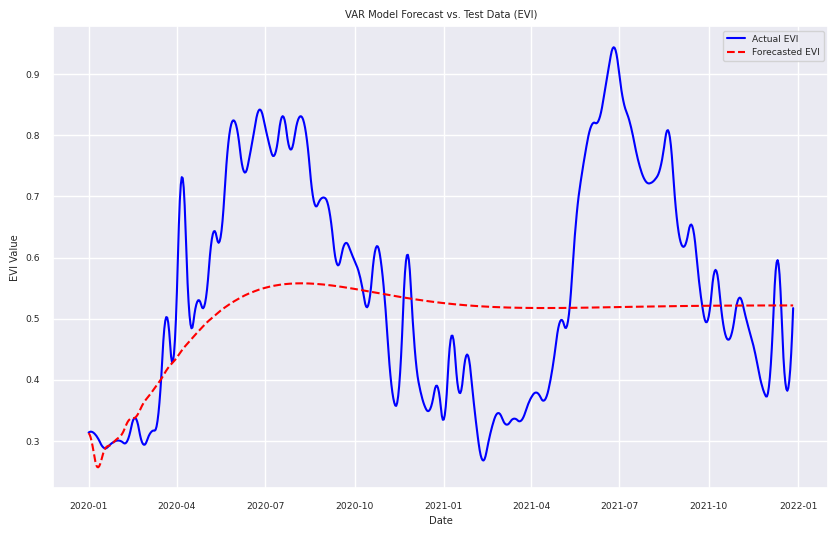

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['EVI'], label='Actual EVI', color='blue')
plt.plot(forecast_df.index, forecast_df['EVI'], label='Forecasted EVI', linestyle='--', color='red')

plt.title('VAR Model Forecast vs. Test Data (EVI)')
plt.xlabel('Date')
plt.ylabel('EVI Value')
plt.legend()
plt.grid(True)
plt.show()

## Lag 27

In [ ]:
model = VAR(training, freq = 'D')
results = model.fit(27)

In [ ]:
# Generate forecasts
forecast = results.forecast(training.values, steps=12)  # Adjust the steps as needed

# Convert forecast array to DataFrame with proper date index
forecast_index = pd.date_range(start=training.index[-1], periods=13, freq='D')[1:]  # Adjusted to include all forecasted periods
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=training.columns)

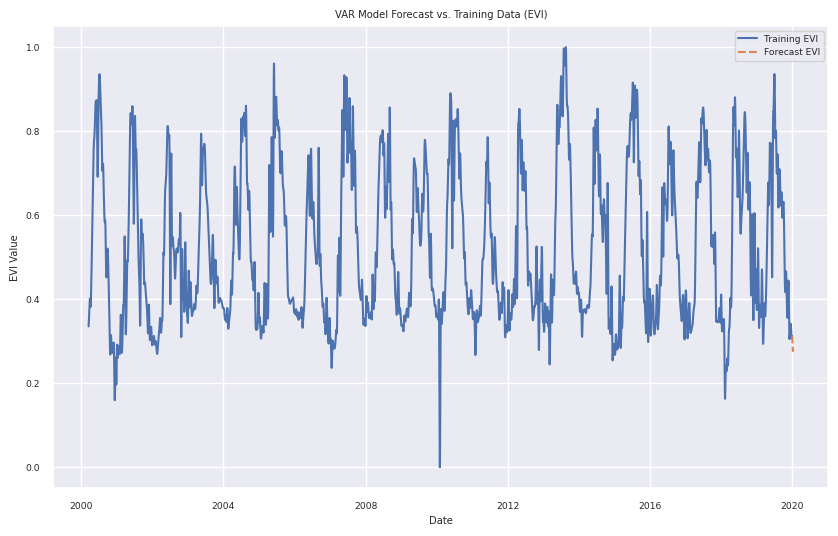

In [ ]:
# Plotting only EVI data
plt.figure(figsize=(10, 6))
plt.plot(training.index, training['EVI'], label='Training EVI')
plt.plot(forecast_df.index, forecast_df['EVI'], label='Forecast EVI', linestyle='--')

plt.title('VAR Model Forecast vs. Training Data (EVI)')
plt.xlabel('Date')
plt.ylabel('EVI Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
forecast = results.forecast(training.values, steps=len(test))  # Forecast the same length as the test data

# Convert forecast array to DataFrame with proper date index
forecast_index = pd.date_range(start=test.index[0], periods=len(test), freq='D')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=test.columns)

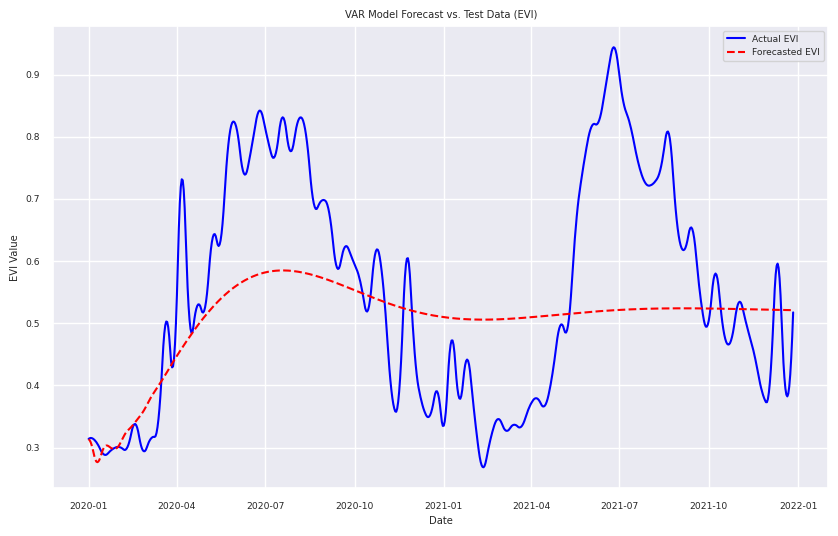

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['EVI'], label='Actual EVI', color='blue')
plt.plot(forecast_df.index, forecast_df['EVI'], label='Forecasted EVI', linestyle='--', color='red')

plt.title('VAR Model Forecast vs. Test Data (EVI)')
plt.xlabel('Date')
plt.ylabel('EVI Value')
plt.legend()
plt.grid(True)
plt.show()

## Lag 365

In [ ]:
model = VAR(training, freq = 'D')
results = model.fit(365)

In [ ]:
# Generate forecasts
forecast = results.forecast(training.values[-365:], steps=12)  # Adjust the steps as needed

# Convert forecast array to DataFrame with proper date index
forecast_index = pd.date_range(start=training.index[-1], periods=13, freq='D')[1:]  # Adjusted to include all forecasted periods
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=training.columns)

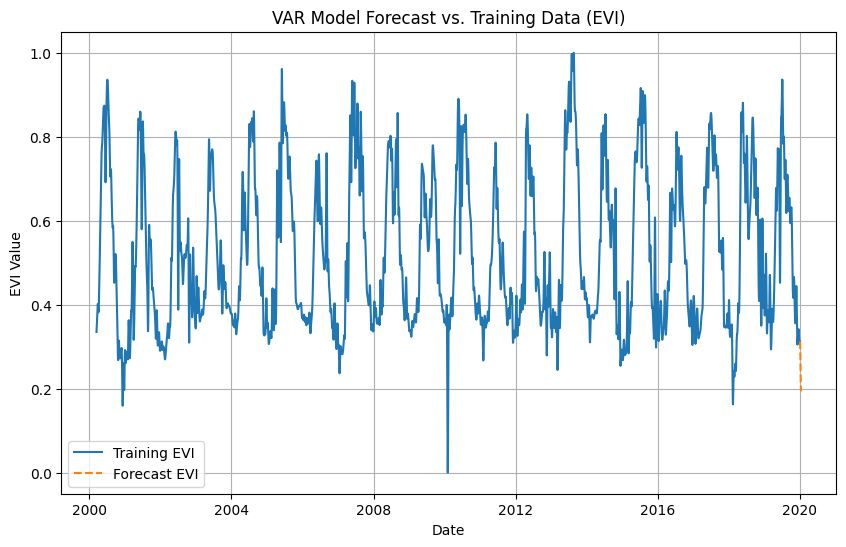

In [ ]:
# Plotting only EVI data
plt.figure(figsize=(10, 6))
plt.plot(training.index, training['EVI'], label='Training EVI')
plt.plot(forecast_df.index, forecast_df['EVI'], label='Forecast EVI', linestyle='--')

plt.title('VAR Model Forecast vs. Training Data (EVI)')
plt.xlabel('Date')
plt.ylabel('EVI Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
forecast = results.forecast(training.values, steps=len(training)) # Forecast the same length as the test data

# Convert forecast array to DataFrame with proper date index
forecast_index = pd.date_range(start=training.index[0], periods=len(training), freq='D')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=training.columns)

In [ ]:
training_metrics = metrics(training['EVI'], forecast_df['EVI'])

# Calculate metrics using the sliced forecast_df
training_metrics = metrics(training['EVI'], forecast_df['EVI'])


print(tabulate(training_metrics))

----  ----------
MAE    0.158753
MSE    0.0382244
RMSE   0.195511
MAPE  32.998
R2    -0.194262
----  ----------


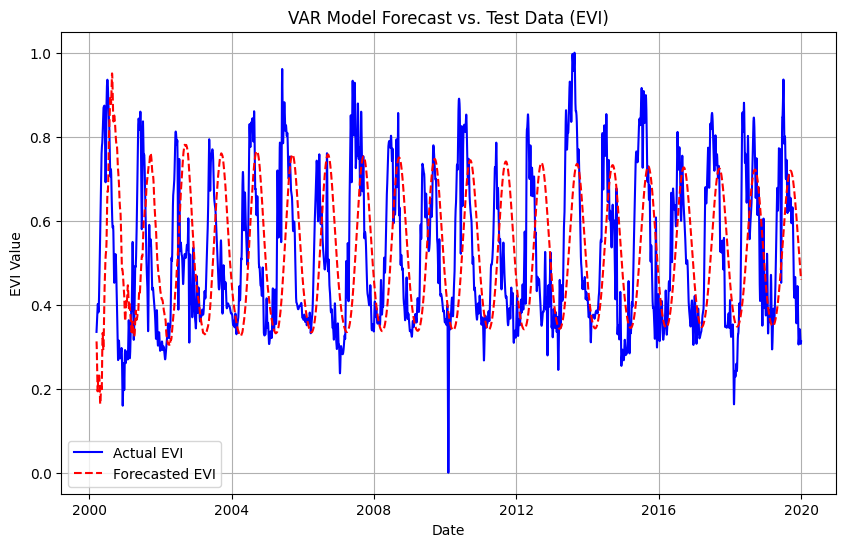

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(training.index, training['EVI'], label='Actual EVI', color='blue')
plt.plot(forecast_df.index, forecast_df['EVI'], label='Forecasted EVI', linestyle='--', color='red')

plt.title('VAR Model Forecast vs. Test Data (EVI)')
plt.xlabel('Date')
plt.ylabel('EVI Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
forecast = results.forecast(training.values, steps=len(test))  # Forecast the same length as the test data

# Convert forecast array to DataFrame with proper date index
forecast_index = pd.date_range(start=test.index[0], periods=len(test), freq='D')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=test.columns)

In [ ]:
mse = mean_squared_error(test[['EVI']], forecast_df[['EVI']])
np.sqrt(mse)

0.1050460559529216

In [ ]:
test_metrics = metrics(test['EVI'], forecast_df['EVI'])

print(tabulate(test_metrics))

----  ----------
MAE    0.0888561
MSE    0.0110347
RMSE   0.105046
MAPE  17.3152
R2     0.671311
----  ----------


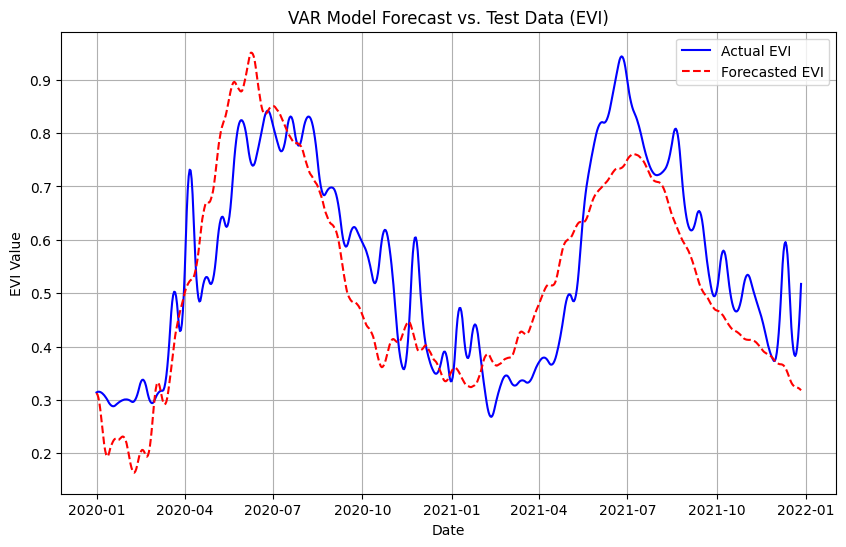

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['EVI'], label='Actual EVI', color='blue')
plt.plot(forecast_df.index, forecast_df['EVI'], label='Forecasted EVI', linestyle='--', color='red')

plt.title('VAR Model Forecast vs. Test Data (EVI)')
plt.xlabel('Date')
plt.ylabel('EVI Value')
plt.legend()
plt.grid(True)
plt.show()

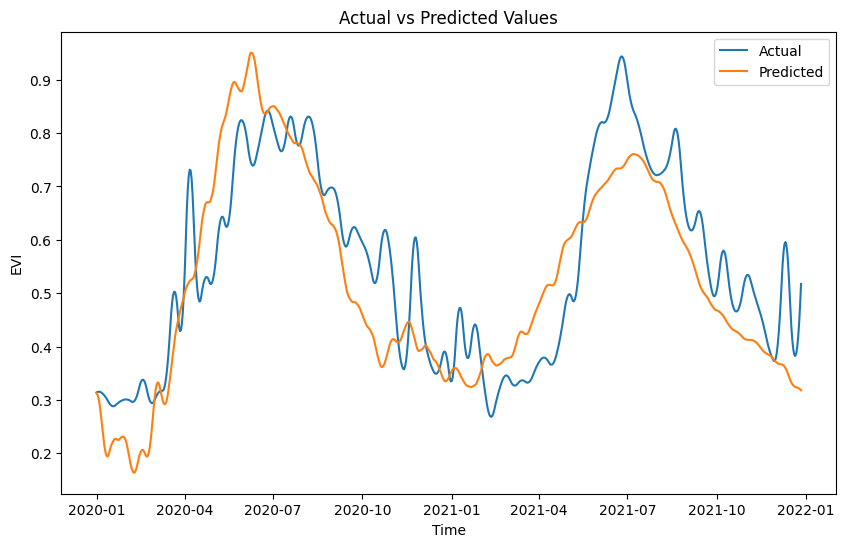

In [ ]:
index_test = test.index

plt.figure(figsize=(10, 6))
plt.plot(index_test, test[['EVI']], label='Actual')
plt.plot(index_test, forecast_df[['EVI']], label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('EVI')
plt.legend()
plt.show()

## LSTM

In [ ]:
# Specify the cut-off point
cut_off_date1 = '2020-01-01' # using the last two years (2020, 2021) as the test data
cut_off_date2 = '2018-01-01'

# Training data
training = df_input.loc[df_input.index < cut_off_date2] # (2000 - 2018)

# Validation data
validation = df_input[(df_input.index >= cut_off_date2) & (df_input.index < cut_off_date1)]  # (2018 - 2019)

# Select all rows on and after the cut-off date
test = df_input.loc[df_input.index >= cut_off_date1] # (2020 - 2021)

Xtrain, Ytrain = training[['TAVG', 'HDEG', 'WSPD', 'ATOT', 'RAIN', 'TR60']], training[['EVI']]
Xval, Yval = validation[['TAVG', 'HDEG', 'WSPD', 'ATOT', 'RAIN', 'TR60']], validation[['EVI']]
Xtest, Ytest = test[['TAVG', 'HDEG', 'WSPD', 'ATOT', 'RAIN', 'TR60']], test[['EVI']]

In [ ]:
# Convert input data to numpy arrays
Xtrain = np.array(Xtrain)
Xval = np.array(Xval)
Xtest = np.array(Xtest)

# Reshape input data to have the shape (number_of_samples, 1, number_of_features)
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], 1, Xtrain.shape[1]))
Xval = np.reshape(Xval, (Xval.shape[0], 1, Xval.shape[1]))
Xtest = np.reshape(Xtest, (Xtest.shape[0], 1, Xtest.shape[1]))

In [ ]:
# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(units=50, input_shape=(1, 6)))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
history = model.fit(Xtrain, Ytrain, epochs=10, batch_size=32, validation_data=(Xval, Yval))

# Evaluate the model on test data
loss = model.evaluate(Xtest, Ytest)
print("Test Loss:", loss)

Epoch 1/10
204/204 [==============================] - 4s 7ms/step - loss: 0.0496 - val_loss: 0.0201
Epoch 2/10
204/204 [==============================] - 1s 4ms/step - loss: 0.0153 - val_loss: 0.0181
Epoch 3/10
204/204 [==============================] - 1s 4ms/step - loss: 0.0134 - val_loss: 0.0162
Epoch 4/10
204/204 [==============================] - 1s 4ms/step - loss: 0.0124 - val_loss: 0.0149
Epoch 5/10
204/204 [==============================] - 1s 4ms/step - loss: 0.0117 - val_loss: 0.0152
Epoch 6/10
204/204 [==============================] - 1s 4ms/step - loss: 0.0112 - val_loss: 0.0145
Epoch 7/10
204/204 [==============================] - 1s 5ms/step - loss: 0.0109 - val_loss: 0.0141
Epoch 8/10
204/204 [==============================] - 1s 6ms/step - loss: 0.0108 - val_loss: 0.0147
Epoch 9/10
204/204 [==============================] - 1s 7ms/step - loss: 0.0108 - val_loss: 0.0144
Epoch 10/10
23/23 [==============================] - 0s 3ms/step - loss: 0.0118
Test Loss: 0.0117830

In [ ]:
evipred = model.predict(Xtest)

23/23 [==============================] - 1s 2ms/step


In [ ]:
# mse for evipred
mse = mean_squared_error(Ytest, evipred)
mse

0.011783056510490482

In [ ]:
evi_pred = pd.DataFrame(evipred, columns=['EVI_pred'])

test_metrics = metrics(Ytest, evi_pred)

print(tabulate(test_metrics))

----  ----------
MAE    0.0853946
MSE    0.0117831
RMSE   0.10855
MAPE  16.4921
R2     0.649019
----  ----------


In [ ]:
np.sqrt(4.702350767188481e-05)

0.006857368859255334

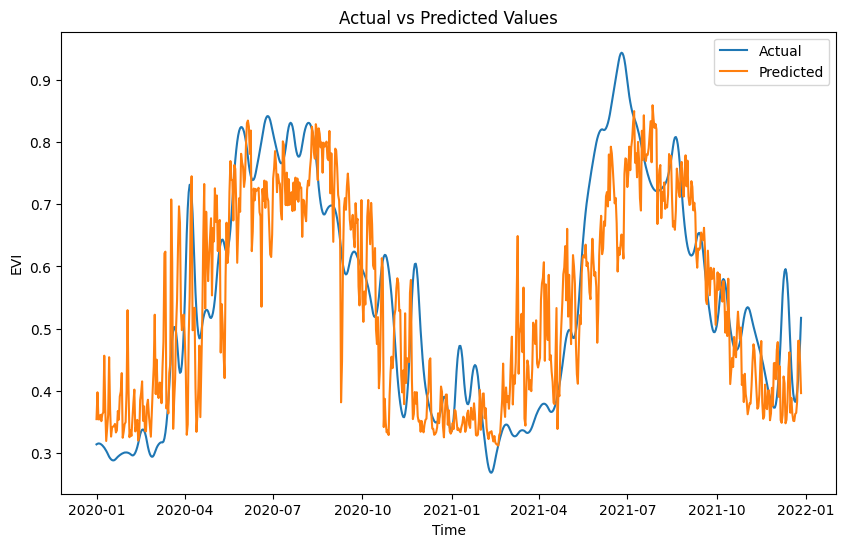

In [ ]:
index_test = test.index

plt.figure(figsize=(10, 6))
plt.plot(index_test, Ytest, label='Actual')
plt.plot(index_test, evipred, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('EVI')
plt.legend()
plt.show()

## Edited Hyperparameters

In [ ]:
# grid search

import itertools
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.activations import sigmoid, tanh, softmax, relu, elu

learning_rate = [0.0001,0.00001]
n_neurons = [5,10,15]
n_epochs = [15, 20]
activation_functions = [sigmoid, softmax, 'leaky_relu']
regularization_terms = [None, l1(0.01), l2(0.01)]  # Adjust regularization strengths as needed

hyper_para = (learning_rate, n_neurons, n_epochs, activation_functions, regularization_terms)
hyper_para_grid = tuple(itertools.product(*hyper_para, repeat=1))
print(len(hyper_para_grid))
for learning_rate, n_neurons, n_epochs, activation_functions, regularization_terms in hyper_para_grid:
  print('lr',learning_rate, 'n_neurons', n_neurons,'n_epochs', n_epochs, 'activation_functions', activation_functions, 'regularization_terms', regularization_terms)

108
lr 0.0001 n_neurons 5 n_epochs 15 activation_functions <function sigmoid at 0x7a12e6128e50> regularization_terms None
lr 0.0001 n_neurons 5 n_epochs 15 activation_functions <function sigmoid at 0x7a12e6128e50> regularization_terms <keras.src.regularizers.L1 object at 0x7a12e5b47010>
lr 0.0001 n_neurons 5 n_epochs 15 activation_functions <function sigmoid at 0x7a12e6128e50> regularization_terms <keras.src.regularizers.L2 object at 0x7a12d4134700>
lr 0.0001 n_neurons 5 n_epochs 15 activation_functions <function softmax at 0x7a12e6113eb0> regularization_terms None
lr 0.0001 n_neurons 5 n_epochs 15 activation_functions <function softmax at 0x7a12e6113eb0> regularization_terms <keras.src.regularizers.L1 object at 0x7a12e5b47010>
lr 0.0001 n_neurons 5 n_epochs 15 activation_functions <function softmax at 0x7a12e6113eb0> regularization_terms <keras.src.regularizers.L2 object at 0x7a12d4134700>
lr 0.0001 n_neurons 5 n_epochs 15 activation_functions leaky_relu regularization_terms None
lr 0

In [ ]:
train_loss_grid, val_loss_grid = list(), list()
best_params = []

def fit_lstm_grid(batch_size):
  min_val_loss = 999
  current_val_loss = 0

  for learning_rate, n_neurons, n_epochs, activation_functions, regularization_terms in hyper_para_grid:
    print('lr',learning_rate, 'n_neurons', n_neurons,'n_epochs', n_epochs, 'activation_functions', activation_functions, 'regularization_terms', regularization_terms)
    model = Sequential()
    model.add(LSTM(n_neurons,return_sequences=False))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=learning_rate),metrics=['accuracy'])

    # fit model
    lstm_model = model.fit(Xtrain,Ytrain, epochs=n_epochs, batch_size=batch_size, validation_data=(Xval, Yval))
    current_val_loss = lstm_model.history['val_loss'][-1]

    if current_val_loss < min_val_loss:
      min_val_loss = current_val_loss
      best_params = [learning_rate, n_neurons, n_epochs, activation_functions, regularization_terms]
      print('best_params',best_params)

  return best_params

In [ ]:
def run_lstm_grid():
  n_batch = 100
  best_params = fit_lstm_grid(n_batch)
  return best_params

In [ ]:
best_params = run_lstm_grid()

lr 0.0001 n_neurons 5 n_epochs 15 activation_functions <function sigmoid at 0x7a12e6128e50> regularization_terms None
Epoch 1/15
65/65 [==============================] - 4s 17ms/step - loss: 0.6900 - accuracy: 4.6154e-04 - val_loss: 0.6895 - val_accuracy: 0.0000e+00
Epoch 2/15
65/65 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 4.6154e-04 - val_loss: 0.6884 - val_accuracy: 0.0000e+00
Epoch 3/15
65/65 [==============================] - 0s 4ms/step - loss: 0.6884 - accuracy: 4.6154e-04 - val_loss: 0.6874 - val_accuracy: 0.0000e+00
Epoch 4/15
65/65 [==============================] - 0s 4ms/step - loss: 0.6877 - accuracy: 4.6154e-04 - val_loss: 0.6865 - val_accuracy: 0.0000e+00
Epoch 5/15
65/65 [==============================] - 0s 4ms/step - loss: 0.6871 - accuracy: 4.6154e-04 - val_loss: 0.6857 - val_accuracy: 0.0000e+00
Epoch 6/15
65/65 [==============================] - 0s 4ms/step - loss: 0.6864 - accuracy: 4.6154e-04 - val_loss: 0.6849 - val_accuracy: 0.00

In [ ]:
print(best_params)

[0.0001, 10, 20, <function softmax at 0x7a12e6113eb0>, None]


In [ ]:
learning_rate = 0.001
n_neurons = 30
n_epochs = 20
act_func = "tanh"
reg_term = None

model = Sequential()

model.add(LSTM(units = n_neurons, input_shape=(1, 6), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units= 5, return_sequences = True))  # Second LSTM layer
model.add(LSTM(units= 2))

model.add(Dense(units = 1, kernel_regularizer=reg_term)) #activation=act_func,

# Compile the model
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Print model summary
model.summary()

# Fit the model
model.fit(Xtrain, Ytrain, epochs=n_epochs, batch_size=32)

Model: "sequential_124"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_152 (LSTM)             (None, 1, 30)             4440      
                                                                 
 dropout_11 (Dropout)        (None, 1, 30)             0         
                                                                 
 lstm_153 (LSTM)             (None, 1, 5)              720       
                                                                 
 lstm_154 (LSTM)             (None, 2)                 64        
                                                                 
 dense_124 (Dense)           (None, 1)                 3         
                                                                 
Total params: 5227 (20.42 KB)
Trainable params: 5227 (20.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
204/204

In [ ]:
lstm_train = pd.DataFrame(model.predict(Xtrain), columns=['EVI_train'])

train_metrics = metrics(Ytrain, lstm_train)

print(tabulate(train_metrics))

204/204 [==============================] - 2s 3ms/step
----  ----------
MAE    0.0775598
MSE    0.0102982
RMSE   0.10148
MAPE  17.4372
R2     0.674981
----  ----------


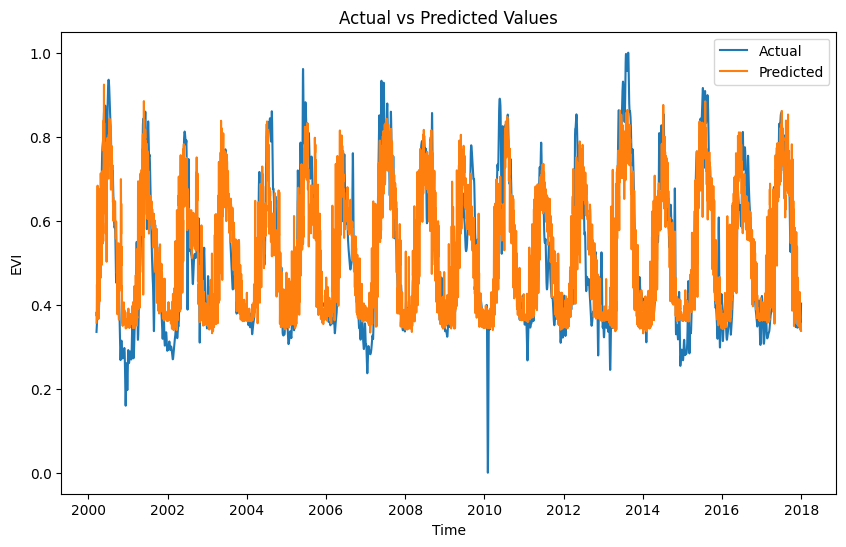

In [ ]:
index_train = training.index

plt.figure(figsize=(10, 6))
plt.plot(index_train, Ytrain, label='Actual')
plt.plot(index_train, lstm_train, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('EVI')
plt.legend()
plt.show()

In [ ]:
lswipred = model.predict(Xtest)

lstm_pred = pd.DataFrame(lswipred, columns=['EVI_pred'])

test_metrics = metrics(Ytest, lstm_pred)
#test_metrics
print(tabulate(test_metrics))

23/23 [==============================] - 0s 2ms/step
----  ----------
MAE    0.0827752
MSE    0.0109109
RMSE   0.104455
MAPE  16.2284
R2     0.674998
----  ----------


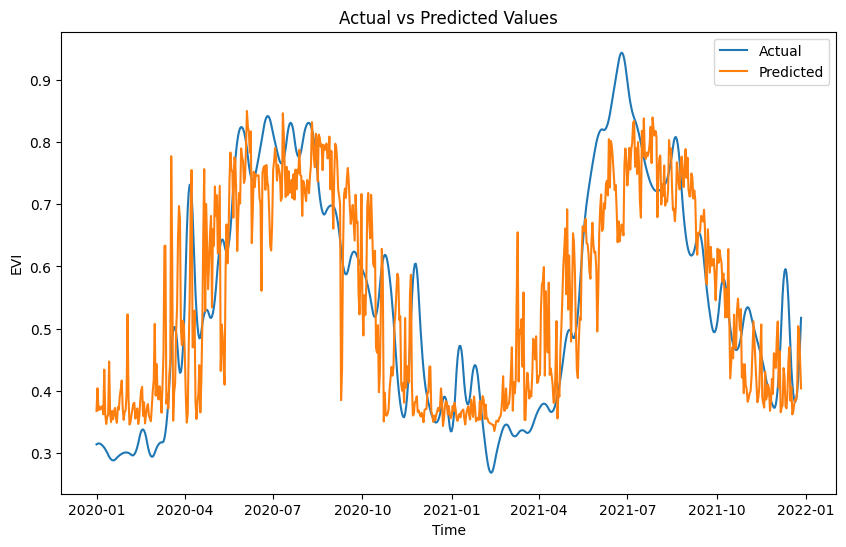

In [ ]:
index_test = test.index

plt.figure(figsize=(10, 6))
plt.plot(index_test, Ytest, label='Actual')
plt.plot(index_test, lswipred, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('EVI')
plt.legend()
plt.show()